In [1]:
# !pip install uv
# !uv pip install datasets huggingface_hub[hf_transfer] qdrant-client stamina rich

In [2]:
import os
import torch
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset

d:\Coding\LLMsAndGenAI\colpali-rag\.colrag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [4]:
dataset = load_dataset("ayush7/nasa-sota-multimodal-images-ds", split="train")


In [5]:
dataset

Dataset({
    features: ['image'],
    num_rows: 441
})

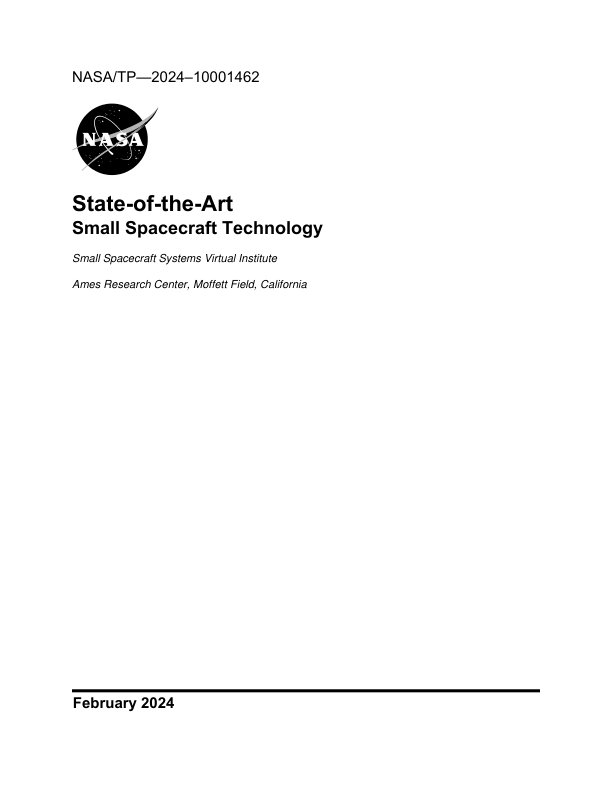

In [6]:
dataset[0]["image"]

In [7]:
qdrant_client = QdrantClient(
    path="vectorstore/colpali_qdrant_store/"
) 

In [8]:
from colpali_engine.models import ColPali, ColPaliProcessor

# Initialize ColPali model and processor
model_name = (
    "davanstrien/finetune_colpali_v1_2-ufo-4bit"  # Use the latest version available
)


In [9]:
torch.__version__

'2.5.1+cu124'

In [10]:
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.21s/it]


In [11]:
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpali-v1.2"
)

In [12]:
sample_image = dataset[0]["image"]
with torch.no_grad():
    sample_batch = colpali_processor.process_images([sample_image]).to(
        colpali_model.device
    )
    sample_embedding = colpali_model(**sample_batch)

In [13]:
sample_embedding

tensor([[[-3.4668e-02,  1.0400e-01,  1.0938e-01,  ..., -4.2725e-02,
          -5.4443e-02, -8.4961e-02],
         [ 1.8677e-02,  6.8054e-03,  9.0820e-02,  ...,  7.6172e-02,
          -3.5889e-02, -7.7637e-02],
         [ 7.3730e-02,  1.0938e-01,  8.3496e-02,  ...,  4.5410e-02,
          -1.0872e-04,  4.1992e-02],
         ...,
         [ 7.9346e-03,  1.4877e-03,  1.1230e-01,  ..., -2.4170e-02,
          -1.4355e-01,  1.3574e-01],
         [-1.2573e-02,  7.6172e-02,  1.5723e-01,  ...,  3.2959e-02,
          -1.0840e-01, -6.7383e-02],
         [-6.5430e-02,  1.2012e-01,  2.1094e-01,  ...,  7.7057e-04,
          -1.1670e-01, -6.2988e-02]]], device='cuda:0', dtype=torch.bfloat16)

In [14]:
sample_embedding.shape

torch.Size([1, 1030, 128])

In [15]:
vector_size = sample_embedding.shape[2]
vector_size

128

In [16]:
collection_name = "ufo"

In [17]:
vector_params = models.VectorParams(
    size=vector_size,
    distance=models.Distance.COSINE,
    multivector_config=models.MultiVectorConfig(
        comparator=models.MultiVectorComparator.MAX_SIM
    ),
)

In [18]:
print(vector_params)

size=128 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)


In [19]:
scalar_quant = models.ScalarQuantizationConfig(
    type=models.ScalarType.INT8,
    quantile=0.99,
    always_ram=False,
)

In [20]:
# client = QdrantClient(url="http://localhost:6333")



In [21]:
qdrant_client.create_collection(
    collection_name=collection_name,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=100
    ),  # it can be useful to swith this off when doing a bulk upload and then manually trigger the indexing once the upload is done
    vectors_config=models.VectorParams(
        size=vector_size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=models.ScalarQuantizationConfig(
                type=models.ScalarType.INT8,
                quantile=0.99,
                always_ram=True,
            ),
        ),
    ),
)

True

In [22]:
batch_size = 6  # Adjust based on your GPU memory constraints

# Use tqdm to create a progress bar
with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        # The images are already PIL Image objects, so we can use them directly
        images = batch["image"]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            # Convert the embedding to a list of vectors
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": "nasa-sota-doc"
                    },  # can also add other metadata/data
                )
            )
        # Upload points to Qdrant
        try:
            qdrant_client.upsert("ufo",points)
        # clown level error handling here 🤡
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress: 444it [1:07:29,  9.12s/it]                         

Indexing complete!


In [23]:
points

[PointStruct(id=438, vector=[[-0.06787109375, -0.0869140625, -0.0155029296875, -0.05859375, -0.002960205078125, -0.08740234375, -0.032958984375, 0.035888671875, -0.0947265625, -0.158203125, -0.03076171875, -0.06298828125, -0.062255859375, -0.047119140625, 0.061767578125, -0.048828125, -0.095703125, -0.158203125, -0.099609375, 0.037353515625, 0.0152587890625, -0.12109375, 0.062255859375, -0.1142578125, 0.099609375, 0.003448486328125, 0.1259765625, -0.006317138671875, 0.0712890625, -0.04296875, 0.006103515625, 0.0615234375, 0.0341796875, -0.1005859375, -0.1171875, 0.06982421875, -0.0311279296875, 0.047119140625, -0.2138671875, -0.07763671875, 0.038818359375, -0.04052734375, 0.052734375, 0.000621795654296875, -0.038818359375, 0.064453125, 0.11328125, 0.080078125, 0.2060546875, 0.0022125244140625, -0.02880859375, -0.08837890625, -0.015869140625, -0.0233154296875, -0.062255859375, 0.047119140625, -0.0291748046875, 0.06591796875, -0.0791015625, 0.08154296875, 0.080078125, -0.11083984375, 0.0

In [24]:
from rich import print as r_print


collection = qdrant_client.get_collection(collection_name)
r_print(collection)

CollectionInfo(
    status=<CollectionStatus.GREEN: 'green'>,
    optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>,
    vectors_count=None,
    indexed_vectors_count=0,
    points_count=441,
    segments_count=1,
    config=CollectionConfig(
        params=CollectionParams(
            vectors=VectorParams(
                size=128,
                distance=<Distance.COSINE: 'Cosine'>,
                hnsw_config=None,
                quantization_config=ScalarQuantization(
                    scalar=ScalarQuantizationConfig(
                        type=<ScalarType.INT8: 'int8'>,
                        quantile=0.99,
                        always_ram=True
                    )
                ),
                on_disk=None,
                datatype=None,
                multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)
            ),
            shard_number=None,
            sharding_method=None,
            replication_factor=None,
            write_consistency_factor=None,
            read_fan_out_factor=None,
            on_disk_payload=None,
            sparse_vectors=None
        ),
        hnsw_config=HnswConfig(
            m=16,
            ef_construct=100,
            full_scan_threshold=10000,
            max_indexing_threads=0,
            on_disk=None,
            payload_m=None
        ),
        optimizer_config=OptimizersConfig(
            deleted_threshold=0.2,
            vacuum_min_vector_number=1000,
            default_segment_number=0,
            max_segment_size=None,
            memmap_threshold=None,
            indexing_threshold=20000,
            flush_interval_sec=5,
            max_optimization_threads=1
        ),
        wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0),
        quantization_config=None
    ),
    payload_schema={}
)

In [25]:
qdrant_client.scroll(collection_name=collection_name, limit=10)


([Record(id=0, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=1, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=2, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=3, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=4, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=5, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=6, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=7, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=8, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
  Record(id=9, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None)],

In [37]:
query_text = "Magnetometers"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[ 0.1348, -0.0349,  0.1055,  ..., -0.0162, -0.0679, -0.0366],
         [ 0.0300, -0.1157, -0.0067,  ...,  0.0952, -0.0215,  0.0410],
         [ 0.0549, -0.0044, -0.0410,  ...,  0.1040,  0.0603, -0.1118],
         ...,
         [ 0.0347,  0.0410, -0.0786,  ..., -0.0086,  0.1768, -0.2422],
         [ 0.0371,  0.0447, -0.0757,  ...,  0.0010,  0.1748, -0.2480],
         [ 0.0471,  0.0142, -0.0251,  ...,  0.0811,  0.1172, -0.1602]]],
       device='cuda:0', dtype=torch.bfloat16)

In [38]:
query_embedding[0].shape

torch.Size([16, 128])

In [39]:
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [40]:
# Search in Qdrant
search_result = qdrant_client.query_points(
    collection_name=collection_name, query=multivector_query, limit=10, timeout=60
)

search_result.points

[ScoredPoint(id=83, version=0, score=13.357417374976286, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=69, version=0, score=13.043384214271523, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=74, version=0, score=11.670378758755483, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=73, version=0, score=11.646530804936162, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=71, version=0, score=10.878567768044196, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=77, version=0, score=10.457381496054666, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=72, version=0, score=10.209432955751161, payload={'source': 'nasa-sota-doc'}, vector=None, shard_key=None, order_value=None),
 Score

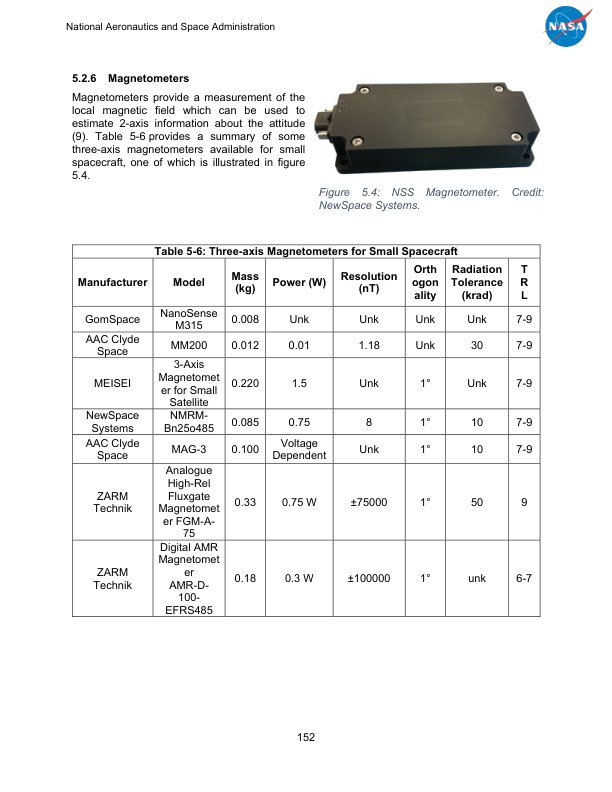

In [41]:
idx = search_result.points[0].id
dataset[idx]["image"]

In [45]:
def search_images_by_text(query_text, top_k=5):
    # Process and encode the text query
    with torch.no_grad():
        batch_query = colpali_processor.process_queries([query_text]).to(
            colpali_model.device
        )
        query_embedding = colpali_model(**batch_query)

    # Convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name=collection_name, query=multivector_query, limit=top_k
    )

    return search_result


# Example usage
query_text = "Magnetometers"
results = search_images_by_text(query_text)

for result in results.points:
    print(result)

id=83 version=0 score=13.43930999044806 payload={'source': 'nasa-sota-doc'} vector=None shard_key=None order_value=None
id=69 version=0 score=13.122387119040813 payload={'source': 'nasa-sota-doc'} vector=None shard_key=None order_value=None
id=74 version=0 score=11.712126308566678 payload={'source': 'nasa-sota-doc'} vector=None shard_key=None order_value=None
id=73 version=0 score=11.678130620266481 payload={'source': 'nasa-sota-doc'} vector=None shard_key=None order_value=None
id=71 version=0 score=10.908180968710438 payload={'source': 'nasa-sota-doc'} vector=None shard_key=None order_value=None


In [46]:
def search_by_text_and_return_images(query_text, top_k=5):
    results = search_images_by_text(query_text, top_k)
    row_ids = [r.id for r in results.points]
    return dataset.select(row_ids)

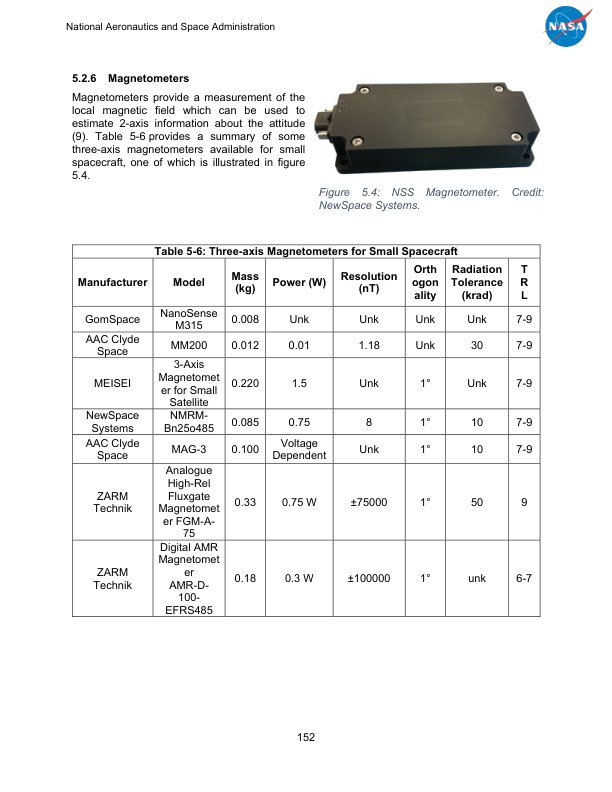

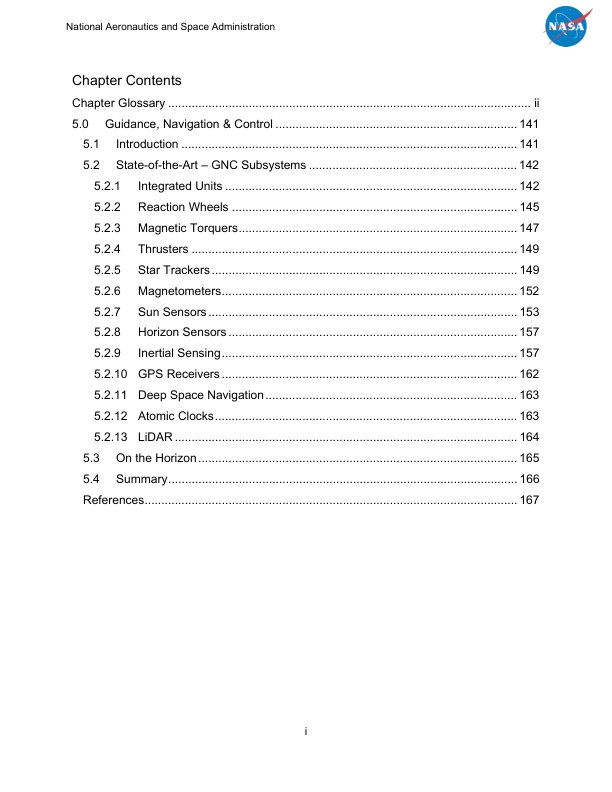

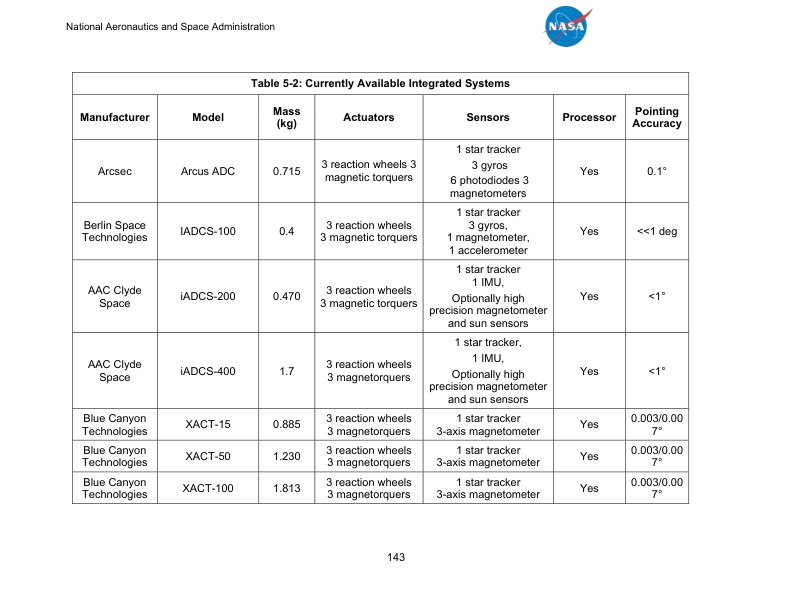

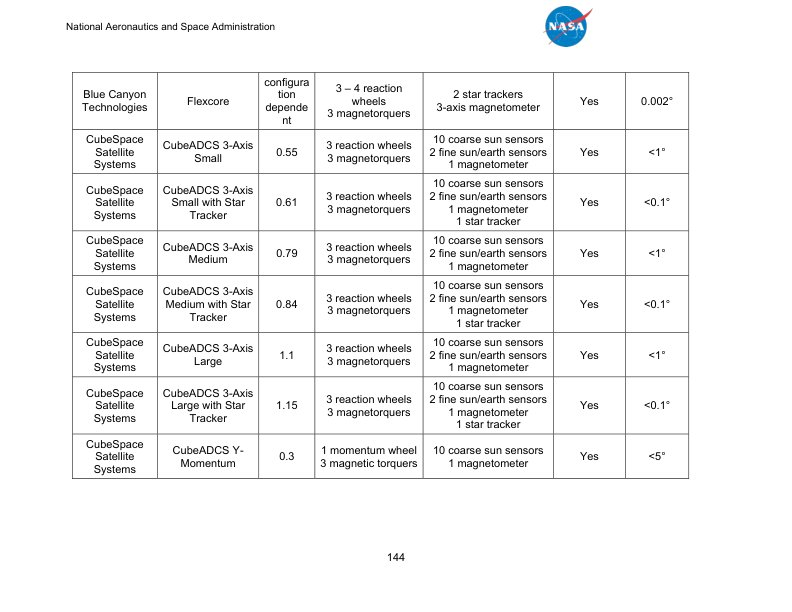

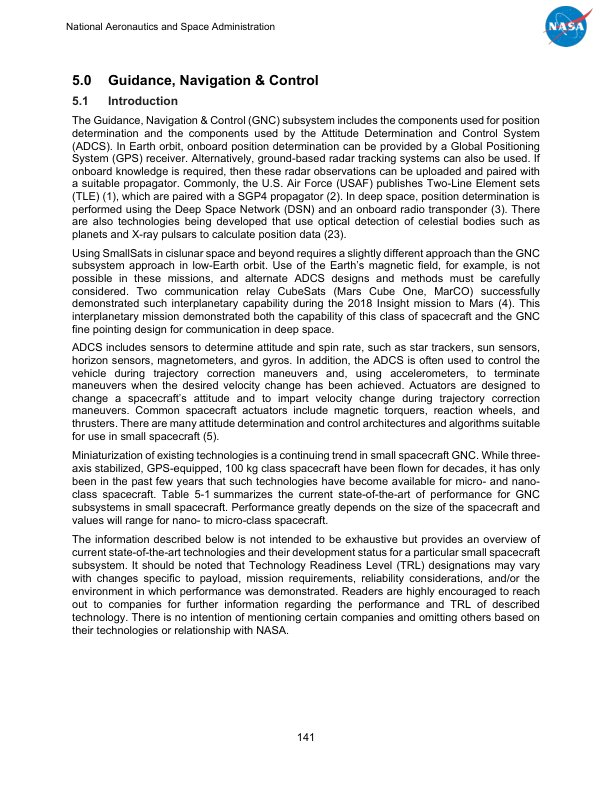

In [48]:
results_ds = search_by_text_and_return_images("Magnetometers")

for row in results_ds:
    # display image
    display(row["image"])